In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [9]:
import backtrader as bt
# <<<Function section>>>

# Momentum Function thanks to Teddy Koker https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/
def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    #params = dict(period=50)
    func = momentum_func

2017-10-31 Enter ANSS - Rank 381.55
2017-10-31 Enter ALGN - Rank 111.90
2017-10-31 Enter ANDV - Rank 42.54
2017-11-30 Leave ANDV - Rank 3.54
2017-11-30 Rebal ALGN - Rank 342.50
2017-11-30 Rebal ANSS - Rank 161.41
2017-11-30 Enter ANF - Rank 12.86
2017-12-29 Leave ALGN - Rank 6.34
2017-12-29 Leave ANF - Rank 12.86
2017-12-29 Rebal ANSS - Rank 17.96
2017-12-29 Enter ALK - Rank 216.27
2017-12-29 Enter ANDV - Rank 209.17
2018-01-31 Leave ALK - Rank 8.05
2018-01-31 Leave ANDV - Rank 3.20
2018-01-31 Rebal ANSS - Rank 265.25
2018-01-31 Enter ALGN - Rank 309.81
2018-01-31 Enter AMD - Rank 222.55
2018-02-28 Leave ALGN - Rank 3.27
2018-02-28 Leave AMD - Rank 2.90
2018-02-28 Leave ANSS - Rank 0.63
2018-02-28 Enter ANF - Rank 12.86
2018-02-28 Enter ACE - Rank 8.69
2018-02-28 Enter ALK - Rank 6.79
2018-03-29 Rebal ACE - Rank 8.69
2018-03-29 Rebal ALK - Rank 6.79
2018-03-29 Rebal ANF - Rank 12.86
2018-04-30 Rebal ACE - Rank 8.69
2018-04-30 Rebal ALK - Rank 6.79
2018-04-30 Rebal ANF - Rank 12.86
2018

<IPython.core.display.Javascript object>


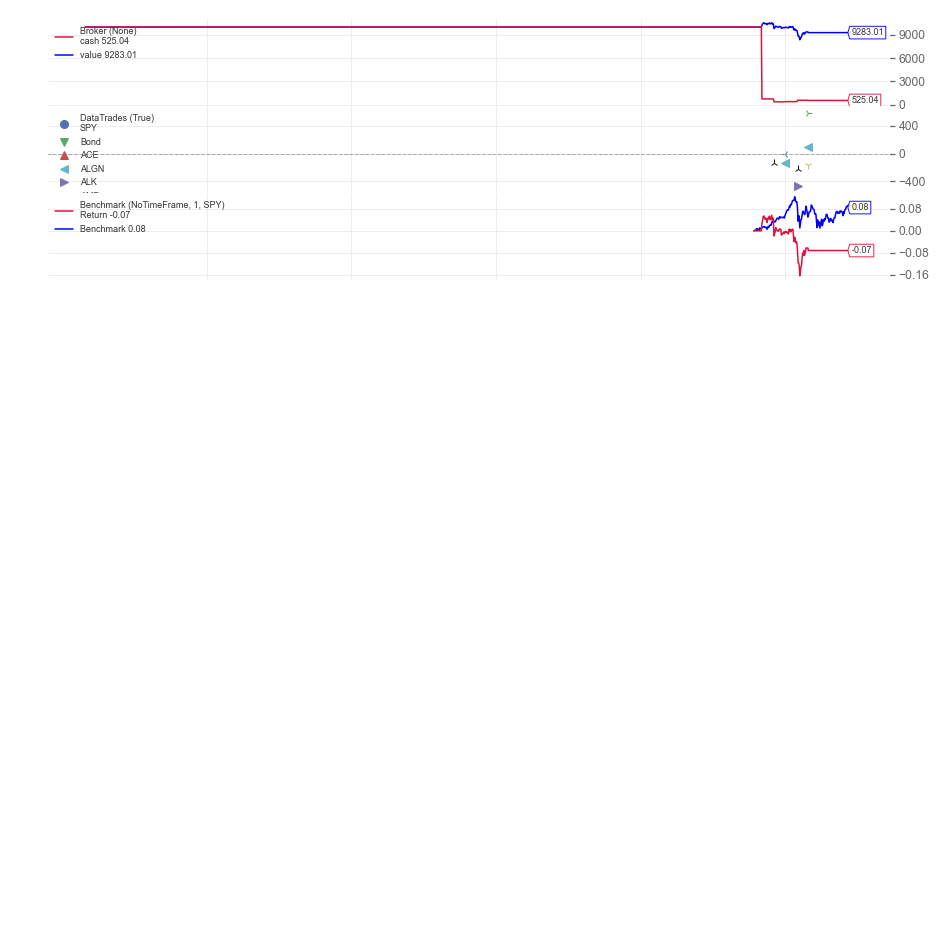

Profit ... or Loss: -716.99


<IPython.core.display.Javascript object>


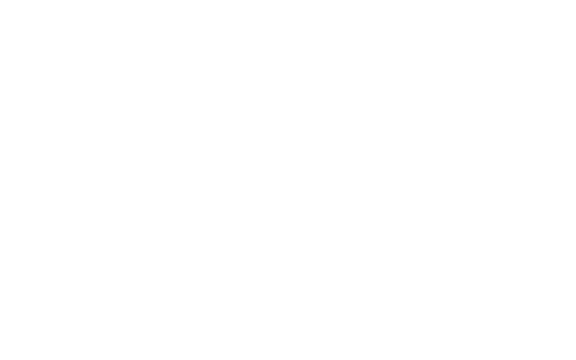

<IPython.core.display.Javascript object>


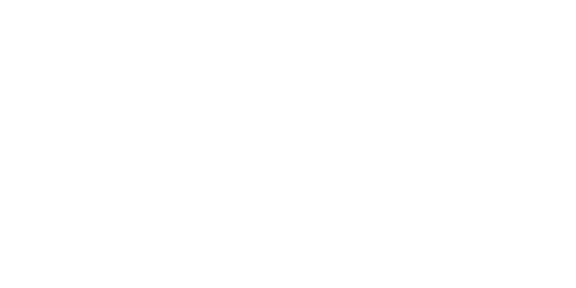

<IPython.core.display.Javascript object>


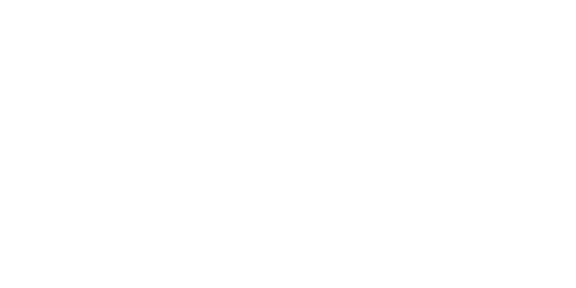

<IPython.core.display.Javascript object>


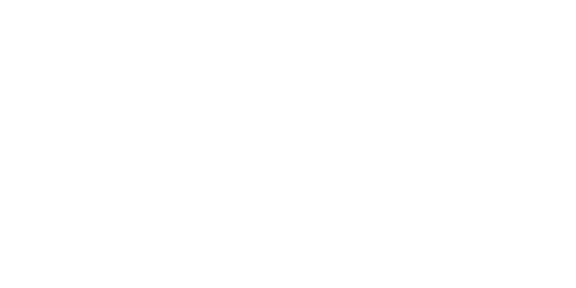

<IPython.core.display.Javascript object>


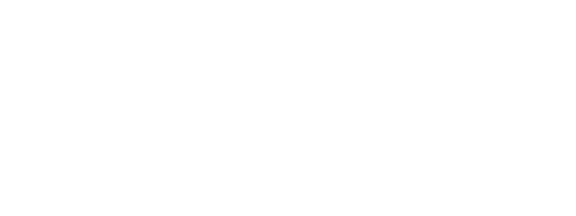

<IPython.core.display.Javascript object>


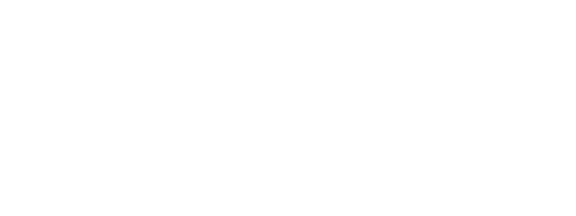

<IPython.core.display.Javascript object>


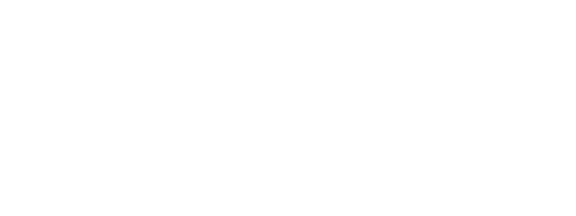

<IPython.core.display.Javascript object>


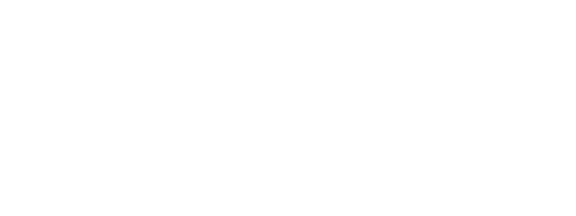

<IPython.core.display.Javascript object>


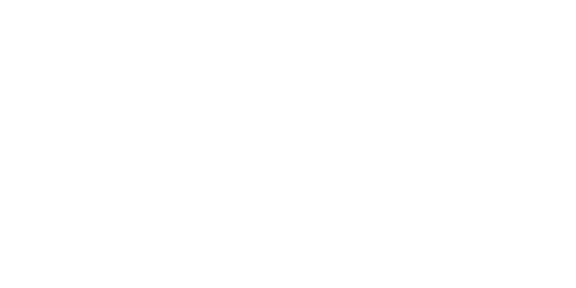

<IPython.core.display.Javascript object>


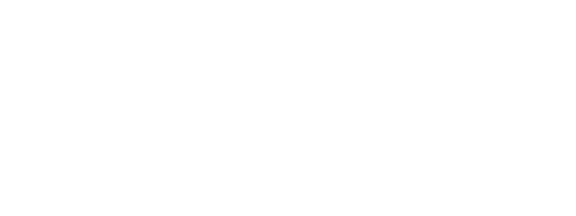

<IPython.core.display.Javascript object>


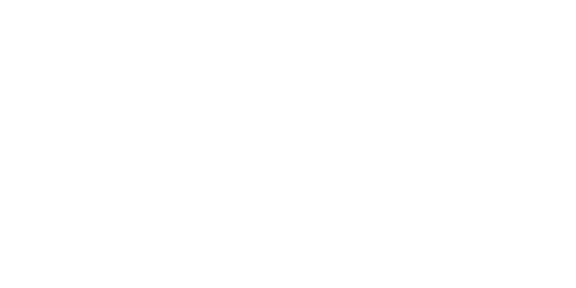

<IPython.core.display.Javascript object>


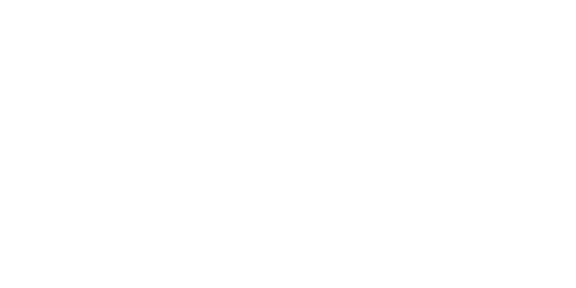

In [10]:
import datetime
import glob
import webbrowser
import os.path
import pandas as pd
import backtrader as bt
import backtrader.analyzers as btanal
import pyfolio as pf
import numpy as np
from scipy.stats import linregress
import quantstats as qs

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,13)

import warnings 
warnings.simplefilter(action='ignore', category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

globalparams = dict(cash=10000,            
                    commission=0.005,
                    reserve=0.05,
                    )

class HoldAllStrategy(bt.Strategy):
    """
    HoldAll Strategy.
    Usually, used for benchmarking test.
    Almost same with the HoldStrategy, it tries to buy all provided securities with the same ratio.
    buy_date: iso-format str, buy order will be created the first market day after the buy_date.
    """
    params = dict(
        buy_date=datetime.today().isoformat(),
    )

    def next(self):
        if self.position:
            return

        if self.get_current_date().isoformat() < self.params.buy_date:
            return

        target_ratio = 1.0 - globalparams["reserve"]
        target_ratio_per_sec = target_ratio / len(self.datas)
        for security in self.datas:
            self.order_target_percent(data=security, target=target_ratio_per_sec)

    def on_order_executed(self, order):
        pass

class St(bt.Strategy):
    params = dict(
        selcperc=0.50,  # percentage of stocks to select from the universe
        rperiod=1,  # period for the returns calculation, default 1 period
        vperiod=30,  # lookback period for volatility - default 36 periods
        mperiod=30,  # lookback period for momentum - default 90 periods
        momentum=Momentum, # parametrize the momentum and its period
        reserve=globalparams["reserve"],  # 5% reserve capital
        monthdays=[1],
        monthcarry=True,
        when=bt.timer.SESSION_START,
        benchmarkstop=True, # If true, no stocks will be bought and no rebalancing will be done if benchmark is below SMAperiod
        SMAperiod=200,
        benchmark_bond=True, # Sell all Stocks and buy Bonds
        jump_momentum=True, # If true, after a time of jump_one (30 days x jump_one) in every month, all the money will be directed to the best performing stock. Rule for that:
                            # In Excel, this is a 0.6 x month return of fund with best past 3 month return plus 0.4 x return of fund with best return, month to date.
        jump_one=0.6,
    )

    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))

    def __init__(self):
        self.bench = self.data0
        self.bond = self.data1
        self.stocks = self.datas[2:]
        # calculate 1st the amount of stocks that will be selected
        self.selnum = int(len(self.stocks) * self.p.selcperc)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        self.perctarget = (1.0 - self.p.reserve) / self.selnum

        self.add_timer(
            when=self.p.when,
            monthdays=self.p.monthdays,
            monthcarry=self.p.monthcarry
        )
        
        jump = True
        
        # returns, volatilities and momentums
        rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.stocks]
        vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
        #ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas]
        ms = [self.p.momentum(d, period=self.p.mperiod) for d in self.stocks]
        
        self.bench_sma = bt.ind.SMA(self.data0, period=self.p.SMAperiod)
        
        # simple rank formula: (momentum * net payout) / volatility
        # the highest ranked: low vol, large momentum, large payout
        self.ranks = {d: m / v for d, v, m in zip(self.stocks, vs, ms)}
        #TODO: does it perform better without the volatility?

        self.bench_filter = self.bench < self.bench_sma
        
    def prenext(self):
        # call next() even when data is not available for all tickers
        self.next()     

    def notify_timer(self, timer, when, *args, **kwargs):
        #print('strategy notify_timer with tid {}, when {} _getminperstatus {}'.
        #      format(timer.p.tid, when, int(self._getminperstatus())))
        if self._getminperstatus() < 0:
            self.rebalance()

    def next(self):
        pass # must be filled with a pass
    
    # This section is for logging of orders in greater detail to figure out whether the strategy is actually having no problem with orders
    '''
    def notify_order(self, order):
        if order.status in [order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        if order.status in [order.Submitted]:
            if order.isbuy():
            
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} {} Price {:.2f} Value {:.2f} Size {} Cash {:.2f}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price , order.created.size, self.broker.getcash()))
            if order.issell():
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                        order.getstatusname(), dt, dn, order.created.price, order.created.size * order.created.price, order.created.size))

            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                dt, dn = self.datetime.date(), order.data._name
                print('Buy {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))

            if order.issell():# Sell
                dt, dn = self.datetime.date(), order.data._name
                print('Sell {} {} Price {:.2f} Value {:.2f} Size {}'.format(
                    dt, dn, order.executed.price, order.executed.value, order.executed.size))


        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
    '''
    
    # Actual order giving by a ranking takes place here
    def rebalance(self):
        
        #if jump == True:
        # Enter Jump Code here    
        
        # sort data and current rank
        ranks = sorted(
            self.ranks.items(),  # get the (d, rank), pair
            key=lambda x: x[1][0],  # use rank (elem 1) and current time "0"
            reverse=True,  # highest ranked 1st ... please
        )
        
        # put top ranked in dict with data as key to test for presence
        rtop = dict(ranks[:self.selnum])

        # For logging purposes of stocks leaving the portfolio
        rbot = dict(ranks[self.selnum:])

        # prepare quick lookup list of stocks currently holding a position
        posdata = [d for d, pos in self.getpositions().items() if pos]
        

        if self.p.benchmarkstop:
            for d in (d for d in posdata):
                if "Bond" == d._name and self.bench_filter:
                    return
                else:
                    if "Bond" == d._name and not self.bench_filter:
                        self.order_target_percent("Bond", target=0.0)
                        self.log('Leave {} due to end of down period'.format(d._name))
                        return

        # remove those no longer top ranked
        # do this first to issue sell orders and free cash
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)
            
        # Triple Momentum: If Benchmark index is below SMA, nothing will be bought or rebalanced
        if self.p.benchmarkstop:
            if self.bench_filter:
                #print('SMA {} - Bench {}'.format(self.bench_sma[0], self.bench[0]))
                if self.p.benchmark_bond:
                    for d in posdata:
                        self.log('Leave {} due to switch to Bonds'.format(d._name))
                        self.order_target_percent(d, target=0.0)
                    self.order_target_percent("Bond", target=0.95)
                    self.log('Buy Bond')
                    bond_flag = True
                    return #Code stops here and skips rebalancing und buying
        
        # rebalance those already top ranked and still there
        for d in (d for d in posdata if d in rtop):
            self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)
            del rtop[d]  # remove it, to simplify next iteration

        # issue a target order for the newly top ranked stocks
        # do this last, as this will generate buy orders consuming cash
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)


def run(args=None):
    cerebro = bt.Cerebro()

    
# <<<Data loading section>>>
    
    # Parse from/to-date
    fromdate = datetime.datetime(2013, 3, 1)
    todate = datetime.datetime(2018, 6, 18)
    
    # Add SPY/QQQ as "Benchmark"
    df0 = pd.read_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\SPY.csv', index_col=0, parse_dates=True)
    benchdata = bt.feeds.PandasData(dataname=df0,name="SPY",fromdate=fromdate, todate=todate,  plot=False)
    cerebro.adddata(benchdata)

    # Add TMF as "Bond"
    df1 = pd.read_csv(r'C:\Users\MMD\PycharmProjects\Trading\Data Mining\Data\TMF.csv', index_col=0, parse_dates=True)
    bonddata = bt.feeds.PandasData(dataname=df1,name="Bond",fromdate=fromdate, todate=todate, plot=False)
    cerebro.adddata(bonddata)    
    
    # add all the data files available in the directory datadir
    for fname in glob.glob(os.path.join(r'C:/Users/MMD/PycharmProjects/Trading/Data Mining/Data/data - Copy', '*')):
        df = pd.read_csv(fname, index_col=0, parse_dates=True)

        if len(df)>100:
            cerebro.adddata(bt.feeds.PandasData(dataname=df,name=os.path.basename(fname).replace(".csv", ""),fromdate=fromdate, todate=todate, plot=False))
            #print(os.path.basename(fname).replace(".csv", "")) #prints the name of the added csv file
            
            
# <<<Cerebro loading section>>>

    # add strategy
    cerebro.addstrategy(St)

    # set the cash, cheat on close and commission
    cerebro.broker.setcash(globalparams["cash"])
    cerebro.broker.set_coc(True)
    cerebro.broker.setcommission(commission=globalparams["commission"])
    
    # Adding Analysers
    cerebro.addanalyzer(btanal.PyFolio)                # Needed to use PyFolio
    cerebro.addanalyzer(btanal.TradeAnalyzer)          # Analyzes individual trades
    
    # If you want to have all data written into a log file
    #cerebro.addwriter(bt.WriterFile, csv=True, out='log.csv')
    
    cerebro.addobserver(bt.observers.Benchmark,
                        data=benchdata,
                        timeframe=bt.TimeFrame.NoTimeFrame)
    
    results = cerebro.run(stdstats=True, tradehistory=True)
    
    
# <<<Performance analysing section section>>>

    cerebro.plot()

    # Basic performance evaluation ... final value ... minus starting cash
    pnl = cerebro.broker.get_value() - globalparams["cash"]
    print('Profit ... or Loss: {:.2f}'.format(pnl))
    
    # Quantstats thanks to https://algotrading101.com/learn/backtrader-for-backtesting/
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    returns.index = returns.index.tz_convert(None)
    qs.reports.html(returns, output='stats.html', title='Momentum')
    webbrowser.open('stats.html')
    
    # Pyfolio if needed
    '''
    returns, positions, transactions, gross_lev = results[0].analyzers.pyfolio.get_pf_items()
    benchmark_rets = pd.Series([0.00004] * len(returns.index), index=returns.index)     
    pf.create_full_tear_sheet(returns, positions, transactions, benchmark_rets=benchmark_rets)
    '''
    
# <<<Execute starting section>>>    
if __name__ == '__main__':
    run()